In [8]:
# ! git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=250, margin=100)
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2',classify=False).eval()
from PIL import Image
img = Image.open('/content/1410507896.jpg') #ИСХОДНОЕ ФОТО
# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path='/content/519783.jpg') #РЕЗУЛЬТАТ ОБРЕЗКИ

In [1]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip uninstall -y torch
!pip install torch==1.9
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.distributed import DistributedSampler

import torchvision
from torchvision import transforms
# os.environ['XLA_USE_BF16'] = '1' #Setting this Environment variable allows TPU to use 'bfloat16'


     |████████████████████████████████| 149.9 MB 28 kB/s 
     |████████████████████████████████| 57 kB 2.7 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.10
    Uninstalling google-api-python-client-1.12.10:
      Successfully uninstalled google-api-python-client-1.12.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.296 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Successfully uninstalled torch-1.10.0+cu111
     |████████████████████████████████| 831.4 MB 2.1 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [2]:
import multiprocessing
import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu

In [3]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import cv2
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
class ImageDS(Dataset):
    
    def __init__(self, path_a, path_b, image_size):
        super().__init__()
        self.image_size = image_size
        self.images_a = self.process_folder(path_a, crop='cartoon')
        self.images_b = self.process_folder(path_b, crop='face')
        self.size_a = len(self.images_a)
        self.size_b = len(self.images_b)
        self.bigger = True if self.size_a >= self.size_b else False
        
    def process_folder(self, path, crop):
        images = []
#         file_names = os.listdir(path)
#         if DATASET_SIZE != -1:
#             file_names = file_names[:DATASET_SIZE]
#         for fname in tqdm(file_names):
        progress_bar = tqdm(total=DATASET_SIZE, desc='Images processed:', position=0)      
        for dirname, _, filenames in os.walk(path):
            if len(images) >= DATASET_SIZE:
                    break
            for filename in filenames:
                if len(images) >= DATASET_SIZE:
                    break
                if filename.endswith('.jpg') or filename.endswith('.png'):
            #                 f_path = path + fname
            #                 image = Image.open(f_path)
            #                 if image.getbands() == ('R', 'G', 'B'):
                    image = Image.open(os.path.join(dirname, filename))
                    progress_bar.update(1)
                    scale = 1.5 if crop == 'cartoon' else 1.0
                    transform = tt.Compose([
                            tt.Resize(int(self.image_size * scale)),
                            tt.CenterCrop(self.image_size),
                            tt.RandomHorizontalFlip(),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                    image = transform(image)
                    images.append(image)
                    
#                     clear_output()
#                     print(len(images), '/', DATASET_SIZE, sep='')
                    if len(images) >= DATASET_SIZE:
                        break
                
        return images
        
    
    def __len__(self):
        return self.size_a if self.bigger else self.size_b
    
    def __getitem__(self, index):
        if self.bigger:
            image_a = self.images_a[index]
            image_b = self.images_b[int(index * (self.size_b / self.size_a))]
        else:
            image_a =  self.images_a[int(index * (self.size_a / self.size_b))]
            image_b =  self.images_b[index]
            
        return image_a, image_b
# # Apples2oranges
# path_tr_a = '../input/apple2orange-dataset/trainA/'
# path_tr_b ='../input/apple2orange-dataset/trainB/'
# path_tst_a = '../input/apple2orange-dataset/testA/'
# path_tst_b = '../input/apple2orange-dataset/testB/'

# # Monet2photo
# path_tr_a = '../input/monet2photo/trainA/'
# path_tr_b ='../input/monet2photo/trainB/'
# path_tst_a = '../input/monet2photo/testA/'
# path_tst_b = '../input/monet2photo/testB/'

# cars2toys
# path_tr_a = '../input/stanford-cars-dataset/cars_train/cars_train/'
# path_tr_b = '../input/toy-cars-annotated-on-yolo-format/'

# faces2cartoons
path_tr_a = '../input/cartoon-faces-googles-cartoon-set/'
path_tr_b ='../input/flickrfaces-dataset-nvidia-128x128/real_faces_128/'
# path_tr_a = '/content/cartoonset100k_jpg'
# path_tr_b ='/content/real_faces_128'


IMAGE_SIZE = 64
BATCH_SIZE = 10
DATASET_SIZE = 320

# train_ds = ImageDS(path_tr_a, path_tr_b, IMAGE_SIZE)
# test_ds = ImageDS(path_tst_a, path_tst_b, IMAGE_SIZE)



# train_sampler = torch.utils.data.distributed.DistributedSampler(
#           train_ds,
#           num_replicas=xm.xrt_world_size(),
#           rank=xm.get_ordinal(),
#           shuffle=True)

# test_sampler = torch.utils.data.distributed.DistributedSampler(
#           test_ds,
#           num_replicas=xm.xrt_world_size(),
#           rank=xm.get_ordinal(),
#           shuffle=False)

# train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=train_sampler, num_workers=4, pin_memory=True)
# test_dl = DataLoader(test_ds, BATCH_SIZE, sampler=test_sampler,num_workers=4, pin_memory=True)



In [8]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [9]:
import pickle
!kaggle datasets download -d kitaef/41-epochs-faces
!unzip 41-epochs-faces.zip
with open('/content/train_dataset', 'rb')as file:
  train_ds = pickle.load(file)

 92% 204M/221M [00:01<00:00, 134MB/s]
100% 221M/221M [00:01<00:00, 123MB/s]
Archive:  41-epochs-faces.zip
  inflating: 1_200_D_A               
  inflating: 1_200_D_B               
  inflating: 1_200_G_A2B             
  inflating: 1_200_G_B2A             
replace train_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace train_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_dataset           



In [12]:
train_ds.size_a
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

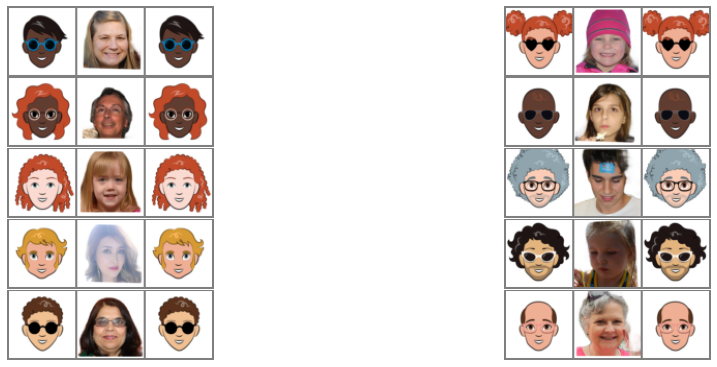

In [15]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def show(a_real, a_trans, a_recov,
         b_real, b_trans, b_recov, 
         grid,
         rows=4):
    
    for i in range(1, rows+1):
        plt.subplot(grid[i-1:i, 0:1])
        plt.imshow(denorm(make_grid([a_real[i-1].detach().cpu(),
                                            a_trans[i-1].detach().cpu(),
                                            a_recov[i-1].detach().cpu()], nrow=rows
                                ).permute(1,2,0)
                      )
                )
        plt.axis('off')
        plt.subplot(grid[i-1:i, 1:2])
        plt.imshow(denorm(make_grid([b_real[i-1].detach().cpu(),
                                            b_trans[i-1].detach().cpu(),
                                            b_recov[i-1].detach().cpu()], nrow=rows
                                ).permute(1,2,0)
                      )
                )
        plt.axis('off')

a_real, a_trans = next(iter(train_dl))
a_recov = a_real
b_real, b_trans = next(iter(train_dl))
b_recov = b_real

rows = 5
plt.figure(figsize=(17, rows*1.3))
grid = plt.GridSpec(rows, 2, wspace = .1, hspace = .01)
show(a_real, a_trans, a_recov, b_real, b_trans, b_recov, grid, rows)

In [39]:
def conv_block(in_ch, out_ch, kernel=3, stride=2, padding=1, normalize=True, activation=nn.LeakyReLU(0.2, inplace=True)):
    layers = [nn.ReflectionPad2d(padding)] if padding > 0 else []
    layers += [nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=0)]
    if normalize:
        layers += [nn.BatchNorm2d(out_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(out_ch, affine=True)]
    if activation:
        layers += [activation]
    return layers

def deconv_block(in_ch, out_ch,
                 kernel=3, stride=1, padding=1,
                 normalize=True,
                 activation=True):
    layers = [nn.Upsample(scale_factor = 2, mode='bilinear'),
              nn.ReflectionPad2d(padding),
              nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=0)]
    if normalize:
        layers += [nn.BatchNorm2d(out_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(out_ch, affine=True)]
    if activation:
        layers += [nn.ReLU(inplace=True)]
    return layers
    
class Res_block(nn.Module):
    
    def __init__(self, in_ch):
        super().__init__()
        self.block = nn.Sequential(nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_ch, in_ch, kernel_size=3),
                                   nn.BatchNorm2d(in_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(in_ch, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_ch, in_ch, kernel_size=3),
                                   nn.BatchNorm2d(in_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(in_ch, affine=True)
                                  )
    def forward(self, x):
        return x + self.block(x)
    
    
class Discriminator(nn.Module):
    
    def __init__(self, in_ch=3, features=[64, 128, 256, 512]):
        super().__init__()
        layers = []
        for out_ch in features:
            layers += conv_block(in_ch, out_ch, kernel=4)
            in_ch = out_ch
        layers += conv_block(features[-1], 1, kernel=4, stride=1, padding=0, normalize=False, activation=nn.Sigmoid())
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x).view(-1, 1)
    
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        layers = []
        layers += conv_block(3, 64, kernel=7, stride=1, padding=3, activation=nn.ReLU(inplace=True))
        layers += conv_block(64,128, activation=nn.ReLU(inplace=True))
        layers += conv_block(128,256, activation=nn.ReLU(inplace=True))
        layers += [Res_block(256)] * 5
        layers += deconv_block(256, 128, activation=nn.ReLU(inplace=True))
        layers += deconv_block(128, 64, activation=nn.ReLU(inplace=True))
        layers += conv_block(64, 3, kernel=7, stride=1, padding=3, normalize=False, activation=nn.Tanh())
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
        
def test():
    D = Discriminator()
    G = Generator()
    test = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
    print(D(test).shape)
    print(G(test).shape)
    print(D)
    print(G)
    
test()


torch.Size([10, 1])
torch.Size([10, 3, 64, 64])
Discriminator(
  (conv): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ReflectionPad2d((1, 1, 1, 1))
    (13): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [40]:
import itertools
import random

class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)
    
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


# custom weights initialization called on netG and netD
def weights_init(m):
    torch.manual_seed(1)
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [56]:
def train_one_epoch(train_dl,
                    netG_A2B, netG_B2A, netD_A, netD_B,
                    cycle_loss, identity_loss, adversarial_loss,
                    optimizer_G,optimizer_D_A, optimizer_D_B,
                    epoch, epochs,
                    device, rank
                   ):
    # i=0
    # progress_bar = tqdm(total=len(train_dl), desc=f'Core: {rank}, batch: {i+1}', position=0)  
    for batch_num, data in enumerate(train_dl):
        if rank == 0:
          print(f'epoch: {epoch} core: {rank} batch: {batch_num}')
        # get batch size data
        real_image_A = data[0].to(device)
        real_image_B = data[1].to(device)
        batch_size = real_image_A.size(0)
        # if rank == 0:
        #     print('1')
        # real data label is 1, fake data label is 0.
        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).uniform_(0.8, 1.1).float().to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).uniform_(0., 0.3).float().to(device)
        ##############################################
        # (1) Update G network: Generators A2B and B2A
        ##############################################
        # Set G_A and G_B's gradients to zero
        optimizer_G.zero_grad()
        # if rank == 0:
        #     print('2')
        # Identity loss
        # G_B2A(A) should equal A if real A is fed
        identity_image_A = netG_B2A(real_image_A)
        loss_identity_A = identity_loss(identity_image_A, real_image_A) * 2.0
        # if rank == 0:
        #     print('3')
        # G_A2B(B) should equal B if real B is fed
        identity_image_B = netG_A2B(real_image_B)
        loss_identity_B = identity_loss(identity_image_B, real_image_B) * 2.0
        # GAN loss
        # GAN loss D_A(G_A(A))
        fake_image_A = netG_B2A(real_image_B)
        fake_output_A = netD_A(fake_image_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
        # GAN loss D_B(G_B(B))
        fake_image_B = netG_A2B(real_image_A)
        fake_output_B = netD_B(fake_image_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)
        # Cycle loss
        recovered_image_A = netG_B2A(fake_image_B)
        loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 3.0

        recovered_image_B = netG_A2B(fake_image_A)
        loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 3.0

        # Combined loss and calculate gradients
        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        # Calculate gradients for G_A and G_B
        errG.backward()
        # if rank == 0:
        #     print('4')
        # Update G_A and G_B's weights
        xm.optimizer_step(optimizer_G)
        # if rank == 0:
        #     print('5')

        ##############################################
        # (2) Update D network: Discriminator A
        ##############################################

        # Set D_A gradients to zero
        optimizer_D_A.zero_grad()

        # Real A image loss
        real_output_A = netD_A(real_image_A)
        errD_real_A = adversarial_loss(real_output_A, real_label)

        # Fake A image loss
#         fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
        fake_output_A = netD_A(fake_image_A.detach())
        errD_fake_A = adversarial_loss(fake_output_A, fake_label)

        # Combined loss and calculate gradients
        errD_A = (errD_real_A + errD_fake_A) / 2

        # Calculate gradients for D_A
        errD_A.backward()
        # Update D_A weights
        xm.optimizer_step(optimizer_D_A)


        ##############################################
        # (3) Update D network: Discriminator B
        ##############################################

        # Set D_B gradients to zero
        optimizer_D_B.zero_grad()

        # Real B image loss
        real_output_B = netD_B(real_image_B)
        errD_real_B = adversarial_loss(real_output_B, real_label)

        # Fake B image loss
#         fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
        fake_output_B = netD_B(fake_image_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_label)

        # Combined loss and calculate gradients
        errD_B = (errD_real_B + errD_fake_B) / 2

        # Calculate gradients for D_B
        errD_B.backward()
        # Update D_B weights
        xm.optimizer_step(optimizer_D_B)
#             progress_bar.set_description(
#                 f"[{epoch}/{epochs - 1}][{i}/{len(train_dl) - 1}] "
#                 f"Loss_D: {(errD_A + errD_B).item():.4f} "
#                 f"Loss_G: {errG.item():.4f} "
#                 f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
#                 f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
#                 f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")

        # i+=1
        # progress_bar.update(1)
        if rank == 0 and (batch_num+1) % 2 == 0:
          a_real = real_image_A
          b_real = real_image_B
          netG_A2B.eval()
          netG_B2A.eval()
          netD_A.eval()
          netD_B.eval()
          with torch.no_grad():
              a_transformed = netG_A2B(a_real)
              b_transformed = netG_B2A(b_real)
              a_recovered = netG_B2A(a_transformed)
              b_recovered = netG_A2B(b_transformed)
          rows = 5
          plt.figure(figsize=(17,rows*1.7))
          grid = plt.GridSpec(rows, 2, wspace = .1, hspace = .01)
          show(a_real, a_transformed, a_recovered,
              b_real, b_transformed, b_recovered,
              grid, rows)
          
          plt.suptitle(t=f'Batch {i+1}/{len(train_dl)}:',
                    y=0.95, x=0.5)
          plt.show()    

          netG_A2B.train()
          netG_B2A.train()
          netD_A.train()
          netD_B.train()
            
    # Update learning rates
    # lr_scheduler_G.step()
    # lr_scheduler_D_A.step()
    # lr_scheduler_D_B.step()

In [57]:
SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.
WRAPPED_D_A = xmp.MpModelWrapper(Discriminator())
WRAPPED_D_B = xmp.MpModelWrapper(Discriminator())
WRAPPED_G_A2B = xmp.MpModelWrapper(Generator())
WRAPPED_G_B2A = xmp.MpModelWrapper(Generator())



def get_dataset():
    # path_tr_a = '../input/cartoon-faces-googles-cartoon-set/'
    # path_tr_b ='../input/flickrfaces-dataset-nvidia-128x128/real_faces_128/'
    # train_ds = ImageDS(path_tr_a, path_tr_b, IMAGE_SIZE)
    return train_ds
def _mp_fn(rank,flags):
    '''
    This function is executed on all the devices when it is spawned.
    Args :
        rank  - Index of the process.
        flags - Arguments you need to pass to each process.
    '''
    torch.manual_seed(1)
    torch.set_default_tensor_type('torch.FloatTensor')
    device = xm.xla_device()
    
    train_ds = SERIAL_EXEC.run(get_dataset)
    data_sampler = DistributedSampler(train_ds,
                                      num_replicas=xm.xrt_world_size(),
                                      rank=xm.get_ordinal(),
                                      shuffle=True)
    train_dl = DataLoader(
                          train_ds,
                          batch_size=flags['batch_size'],
                          sampler=data_sampler,
                          num_workers=flags['num_workers'],
                          drop_last=True)
    

#     netG_A2B.apply(weights_init)
#     netG_B2A.apply(weights_init)
#     netD_A.apply(weights_init)
#     netD_B.apply(weights_init)

#     netG_A2B.load_state_dict(torch.load('../input/41-epochs-faces/5000_G_A2B'))
#     netG_B2A.load_state_dict(torch.load('../input/41-epochs-faces/5000_G_B2A'))
    # netD_A.load_state_dict(torch.load('/content/5000_D_A'))
    # netD_B.load_state_dict(torch.load('/content/5000_D_B'))
    netG_A2B = WRAPPED_G_A2B.to(device)
    netG_B2A = WRAPPED_G_B2A.to(device)
    netD_A = WRAPPED_D_A.to(device)
    netD_B = WRAPPED_D_B.to(device)
    optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                   lr=flags['lr'], betas=(0.5, 0.999))
    optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=flags['lr'], betas=(0.5, 0.999))
    optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=flags['lr'], betas=(0.5, 0.999))
    cycle_loss = torch.nn.L1Loss()
    identity_loss = torch.nn.L1Loss()
    adversarial_loss = torch.nn.MSELoss()
    lr=0.0002
    epochs = 1
    decay_epochs=100
    xm.master_print('Training has started\n')
    for epoch in range(flags['nb_epochs']):
        xm.master_print(f'Epoch[{epoch+1}/{flags["nb_epochs"]}] has started\n')
        parallel_loader = pl.ParallelLoader(train_dl, [device]).per_device_loader(device)
        train_one_epoch(parallel_loader,
                        netG_A2B, netG_B2A, netD_A, netD_B,
                        cycle_loss, identity_loss, adversarial_loss,
                        optimizer_G,optimizer_D_A, optimizer_D_B, epoch, flags['nb_epochs'],
                        device, rank)
        xm.master_print(f'Epoch[{epoch+1}/{flags["nb_epochs"]}] has completed\n')
#         del parallel_loader
#         gc.collect()

In [ ]:
# applying multiprocessing so that images get trained different on      # cores of kaggle-tpuG_A2B = Generator().float()G_B2A = Generator().float()

flags = {
         'batch_size': 10,
         'lr':0.0016,
         'nb_epochs':5,
         'num_workers': 8
        }     
xmp.spawn(_mp_fn, args=(flags,), nprocs=8, start_method='fork')